### Import Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

In [ ]:
# Load Cleaned Data and view head
df = pd.read_csv("../../Cleaned Data/Cleaned_National_Irish_Weather_Solar_2024.csv")

# Convert date column from string to datetime (stored/displayed as YYYY-MM-DD)
df['date'] = pd.to_datetime(df['date'], dayfirst=True)

# Sort in order of date
df = df.sort_values('date').reset_index(drop=True)

df.head()

,date,rain,maxtp,mintp,cbl,glorad,solargen
0,2024-01-01,11.93,10.57,3.03,981.90,64.44,471.02
1,2024-01-02,5.77,10.22,6.53,973.32,125.44,601.80
2,2024-01-03,2.10,9.21,5.46,981.98,210.22,1286.11
3,2024-01-04,1.18,8.17,2.52,991.51,309.00,2788.48
4,2024-01-05,0.36,8.18,2.28,1001.11,314.89,2966.48


### Create Lagged Features (Solargen, Weather + Calendar Features)

In [64]:
# Create lag features for solargen and weather variables

# Drop any old lag features if re running  cell
df = df.loc[:, ~df.columns.str.contains('lag_')].copy()

for i in range(1, 3):  #  lags
    df[f'solargen_lag_{i}'] = df['solargen'].shift(i)
    df[f'rain_lag_{i}'] = df['rain'].shift(i)
    df[f'maxtp_lag_{i}'] = df['maxtp'].shift(i)
    df[f'mintp_lag_{i}'] = df['mintp'].shift(i)

# Add seasonal calendar features
df['dayofyear'] = df['date'].dt.dayofyear
df['month'] = df['date'].dt.month



### Drop Missing Rows (Due to Lagging)

In [65]:
df_model = df.dropna().copy()
df_model.shape


(364, 17)

In [66]:
df_model.head()


,date,rain,maxtp,mintp,cbl,glorad,solargen,dayofyear,month,solargen_lag_1,rain_lag_1,maxtp_lag_1,mintp_lag_1,solargen_lag_2,rain_lag_2,maxtp_lag_2,mintp_lag_2
2,2024-01-03,2.10,9.21,5.46,981.98,210.22,1286.11,3,1,601.80,5.77,10.22,6.53,471.02,11.93,10.57,3.03
3,2024-01-04,1.18,8.17,2.52,991.51,309.00,2788.48,4,1,1286.11,2.10,9.21,5.46,601.80,5.77,10.22,6.53
4,2024-01-05,0.36,8.18,2.28,1001.11,314.89,2966.48,5,1,2788.48,1.18,8.17,2.52,1286.11,2.10,9.21,5.46
5,2024-01-06,0.26,7.64,-0.04,1013.68,348.00,2992.68,6,1,2966.48,0.36,8.18,2.28,2788.48,1.18,8.17,2.52
6,2024-01-07,0.08,3.92,-2.10,1022.29,308.89,2828.50,7,1,2992.68,0.26,7.64,-0.04,2966.48,0.36,8.18,2.28


### Define Features and Target

In [67]:
# Define predictor and target variables
lag_features = [col for col in df_model.columns if 'lag' in col]
calendar_features = ['dayofyear', 'month']

X = df_model[lag_features + calendar_features]
y = df_model['solargen']

### Train/Test Split (Time-Ordered)

In [68]:
### Train/Test Split (Time-Ordered)

# 80% train - 20% test 
split_index = int(len(df_model) * 0.8)

X_train = X.iloc[:split_index]
X_test = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_test = y.iloc[split_index:]


### Fit XGBoost Time Series Model

In [71]:
### Fit XGBoost Time Series Model

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=150,
    learning_rate=0.03,
    max_depth=2,
    reg_lambda=10,
    reg_alpha=3,
    random_state=42
)


model.fit(X_train, y_train)


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


### Evaluate Model Performance (Baseline)

In [72]:
### Evaluate Model Performance (Baseline)

# Predict on train and test
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate on train set
r2_train = r2_score(y_train, y_train_pred)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
mae_train = mean_absolute_error(y_train, y_train_pred)

print(f"Train: R²: {r2_train:.3f} | RMSE: {rmse_train:.2f} | MAE: {mae_train:.2f}")

# Evaluate on test set
r2_test = r2_score(y_test, y_test_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"Test : R²: {r2_test:.3f} | RMSE: {rmse_test:.2f} | MAE: {mae_test:.2f}")


Train: R²: 0.720 | RMSE: 2902.59 | MAE: 2274.59
Test : R²: -4.497 | RMSE: 4730.68 | MAE: 4377.43


### Visualise Solar Generation data over time to fix Train/Test Split 

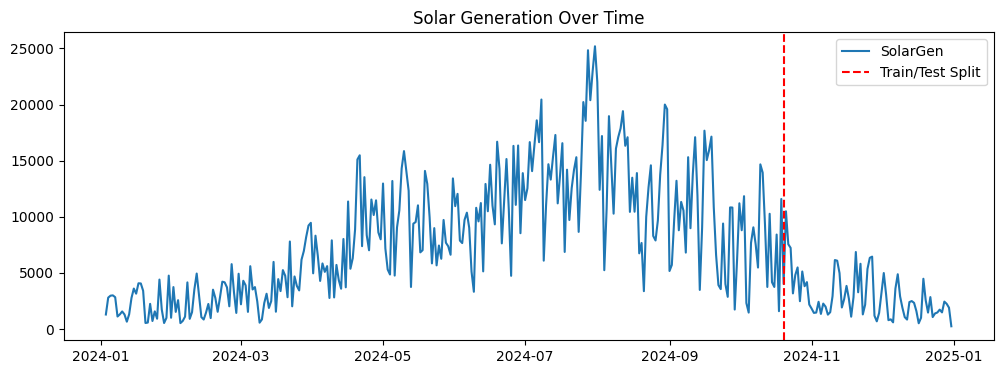

In [73]:
plt.figure(figsize=(12, 4))
plt.plot(df_model['date'], df_model['solargen'], label='SolarGen')
plt.axvline(df_model['date'].iloc[split_index], color='red', linestyle='--', label='Train/Test Split')
plt.title('Solar Generation Over Time')
plt.legend()
plt.show()

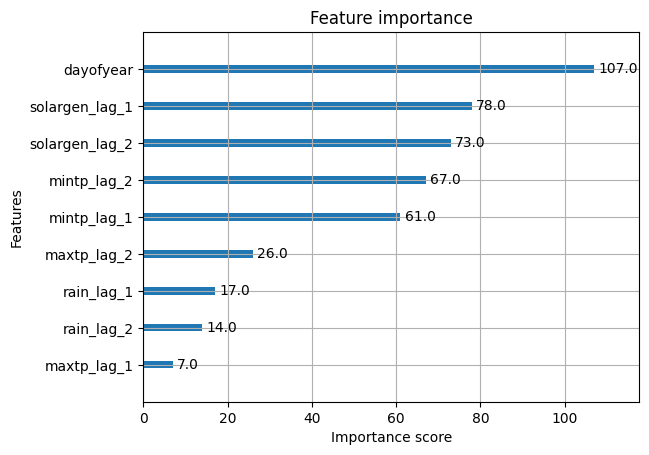

In [74]:
xgb.plot_importance(model, max_num_features=10)
plt.show()
